# 线性回归 Linear Regression
CopyRight: Zhu Shatong , Tongji University
本notebook所有算法均为手写，不使用任何库函数。

（算法设计部分）目录：
1. 准备工作：数据的导入与相关预处理，相关工具函数的定义
2. （单变量线性回归的）批量梯度下降法 Batch Gradient Descent
3. 小批量梯度下降法 Mini Batch Gradient Descent（在批量方面进行了改进）
4. 自适应梯度下降法 Adagrad（在学习率方面进行了改进）
5. 多变量线性回归 Multivariate Linear Regression（在特征方面进行了改进，拓展到多个特征）
6. L1正则化 L1 Regularization（也就是Lasso Regression，应对多变量的过拟合）


分界线——起始
算法设计部分，为完整的思维过程，含相关函数的使用范例，非必要请勿修改

## 0. 数据的导入与相关预处理
在这一section, 我们将会负责导入数据，并对数据进行一些预处理，以便于后续的操作。
data：
我们首先导入的文件为 `data.xlsx` ，将它存储在data变量中。这个文件中包含了两列数据，分别为 `x` 和 `y` 。
我们将会使用这些数据来进行线性回归的训练与可视化。
请注意，在后续本notebook中使用其他数据的时候，请勿再次命名为data。

数据来源：
[Data on length-weight and length-length relationships, mean condition factor, and gonadosomatic index of Rutilus rutilus and Perca fluviatilis from the Ob River basin, Western Siberia - ScienceDirect](https://www.sciencedirect.com/science/article/pii/S2352340922002785?via%3Dihub#fig0004)

In [1]:
# 这一code block用来import需要的库

import pandas as pd  # 用来读取excel等文件
import random  # 用来进行随机打乱数据
import numpy as np  # 用来进行矩阵运算，应对多变量线性回归


In [2]:
# 这一code block用来读取数据

data = pd.read_excel("data.xlsx")  # 读取excel文件（单变量线性回归——测试文件）


In [3]:
# 这一code block用来对读取的数据进行一些处理

# 从数据框架中提取x和y值
x_values = data['x'].values
y_values = data['y'].values

## 0.工具函数
在这一section, 我们将会定义一些工具函数，以便于后续的操作。
目录：
1. 可视化工具函数
2. 线性回归模型计算
3. 损失函数计算

In [4]:
# 可视化工具函数
# 对于数据点与拟合直线的可视化
def plot_data_and_line(x_values, y_values, theta_0_final, theta_1_final, cost_history, title):
    """
    Plot data points and the fitted line.
    
    :param x_values: 这是一个list，包含了所有的x值
    :param y_values: 这是一个list，包含了所有的y值
    :param theta_0_final: 这是一个float，表示最终的theta_0
    :param theta_1_final: 这是一个float，表示最终的theta_1
    :param cost_history: 这是一个list，包含了每一次迭代后的损失函数值
    :param title: 这是一个string，表示图像的标题
    :return: 返回一个图像
    """
    import matplotlib.pyplot as plt  # 用来画图

    plt.figure(figsize=(12, 5))

    # Subplot 1: Linear Regression
    # 这个subplot用来画出数据点和拟合直线
    plt.subplot(1, 2, 1)
    plt.scatter(x_values, y_values, color='blue', label='Original Data')  # 这里的scatter用来画出数据点
    plt.plot(x_values, [f_theta(x, theta_0_final, theta_1_final) for x in x_values], color='red',
             label='Linear Regression')  # 这里的列表表达式用来画出拟合直线
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)  # 显示网格

    # Subplot 2: Cost function history
    # 这个subplot用来画出损失函数的变化
    plt.subplot(1, 2, 2)
    plt.plot(cost_history, color='green')  # 这里的plot用来画出损失函数的变化
    plt.title('Cost Function History')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.grid(True)  # 显示网格

    plt.tight_layout()  # 调整子图之间的间距
    plt.show()

hypothesis:
$$f_\theta(x)=\theta_0+\theta_1x$$

In [5]:
def f_theta(x, theta_0, theta_1):
    """
    Linear regression model.
    
    :param x: 这是一个float，表示输入的x值
    :param theta_0: 这是一个float，表示theta_0
    :param theta_1: 这是一个float，表示theta_1
    :return: 这是一个float，表示预测值
    """
    return theta_0 + theta_1 * x

cost fuction:
$$ J(\theta_0,\theta_1)=\frac1{2N}\sum_{i=1}^N(f_\theta(x^{(i)})-y^{(i)})^2 $$

In [6]:
def compute_cost(x_values, y_values, theta_0, theta_1):
    """
    Compute the cost function.
    
    :param x_values: 这是一个list，包含了所有的x值
    :param y_values: 这是一个list，包含了所有的y值
    :param theta_0: 这是一个float，表示theta_0
    :param theta_1: 这是一个float，表示theta_1
    :return: 这是一个float，表示损失函数的值
    """

    # 计算的公式为：J(theta_0, theta_1) = 1/2N * sum((f_theta(x_i) - y_i)^2)
    N = len(x_values)
    total_error = 0
    for i in range(len(x_values)):
        total_error += (f_theta(x_values[i], theta_0, theta_1) - y_values[i]) ** 2
    return total_error / (2 * N)

## 1. 批量梯度下降法 Batch Gradient Descent

$$ \begin{gathered}
repeat until convergence \{ \\
\begin{aligned}\theta_j:=\theta_j-\alpha\frac{\partial}{\partial\theta_j}J(\theta_0,\theta_1)\end{aligned} \\
\begin{aligned}  \} (\text{for }j=1\text{ and }j=0)\end{aligned} 
\end{gathered} $$

Repeat until convergece:
$$ \begin{aligned}\theta_0{:}&=\theta_0-a\frac1N\sum_{i=1}^N(f_\theta\big(x^{(i)}\big)-y^{(i)})\\\theta_1{:}&=\theta_1-a\frac1N\sum_{i=1}^N(f_\theta\big(x^{(i)}\big)-y^{(i)})x^{(i)}\end{aligned}$$

In [7]:
def gradient_descent(x_values, y_values, alpha=0.05, convergence_threshold=1e-8, max_iterations=10000):
    """
    Perform gradient descent to learn theta_0 and theta_1.
    
    :param x_values: 这是一个list，包含了所有的x值
    :param y_values: 这是一个list，包含了所有的y值
    :param alpha: 这是一个float，表示学习率
    :param convergence_threshold: 这是一个float，表示收敛阈值
    :param max_iterations: 这是一个int，表示最大迭代次数
    :return: 这是一个tuple，包含了theta_0, theta_1, cost_history，分别表示最终的theta_0, theta_1和损失函数的变化
    """

    # 计算公式为： theta_j = theta_j - alpha * 1/N * sum((f_theta(x_i) - y_i) * x_i)

    theta_0 = 0  # 初始化theta_0
    theta_1 = 0  # 初始化theta_1
    N = len(x_values)  # 样本数量

    cost_history = []  # 用来保存损失函数的变化
    for _ in range(max_iterations):  # 进行迭代
        sum_theta_0 = 0  # 用来计算theta_0的梯度
        sum_theta_1 = 0  # 用来计算theta_1的梯度
        for i in range(N):
            error = f_theta(x_values[i], theta_0, theta_1) - y_values[i]  # 计算误差
            sum_theta_0 += error
            sum_theta_1 += error * x_values[i]
        # 注意，所有的theta的更新都是在同一时刻进行的
        theta_0 -= alpha * (1 / N) * sum_theta_0
        theta_1 -= alpha * (1 / N) * sum_theta_1
        cost_history.append(compute_cost(x_values, y_values, theta_0, theta_1))  # 计算损失函数的值

        if len(cost_history) > 1 and abs(cost_history[-1] - cost_history[-2]) < convergence_threshold:
            # 如果损失函数的变化小于收敛阈值，则停止迭代
            break

    return theta_0, theta_1, cost_history

In [8]:
# 这一code block用来调用上面的函数
theta_0_final, theta_1_final, cost_history = gradient_descent(x_values, y_values)

# 打印最终的theta_0, theta_1, cost
theta_0_final, theta_1_final, cost_history[-1]

(-0.6085237464967597, 2.015293119861981, 0.0032082936570863485)

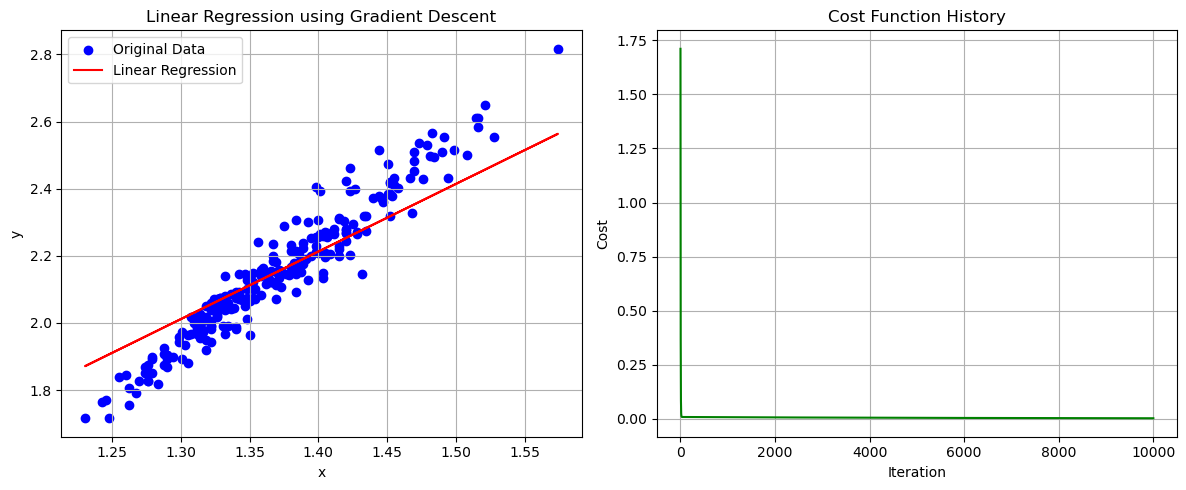

In [9]:
# 这一code block用来画出数据点和拟合直线
plot_data_and_line(x_values, y_values, theta_0_final, theta_1_final, cost_history,
                   'Linear Regression using Gradient Descent')

## 2. 小批量梯度下降法 Mini Batch Gradient Descent（在批量方面进行了改进）
$$\begin{aligned}\theta_0&:=\theta_0-a\frac1{N_k}\sum_{i=1}^{N_k}(f_\theta\big(x^{(i)}\big)-y^{(i)})\\\theta_1&:=\theta_1-a\frac1{N_k}\sum_{i=1}^{N_k}(f_\theta\big(x^{(i)}\big)-y^{(i)})x^{(i)}\end{aligned}$$

In [10]:
def mini_batch_gradient_descent(x_values, y_values, batch_size=5, alpha=0.05, convergence_threshold=1e-8,
                                max_iterations=10000):
    """
    Perform mini batch gradient descent to learn theta_0 and theta_1.
    
    :param x_values:  这是一个list，包含了所有的x值
    :param y_values:  这是一个list，包含了所有的y值
    :param batch_size:  这是一个int，表示batch的大小
    :param alpha:  这是一个float，表示学习率
    :param convergence_threshold:  这是一个float，表示收敛阈值
    :param max_iterations:  这是一个int，表示最大迭代次数
    :return:  这是一个tuple，包含了theta_0, theta_1, cost_history，分别表示最终的theta_0, theta_1和损失函数的变化
    """

    theta_0 = 0  # 初始化theta_0
    theta_1 = 0  # 初始化theta_1
    N = len(x_values)
    cost_history = []

    for _ in range(max_iterations):
        # 对数据进行随机打乱
        combined = list(zip(x_values, y_values))  # 将x_values和y_values打包成一个list
        random.shuffle(combined)  # 对打包后的list进行随机打乱
        x_values[:], y_values[:] = zip(*combined)  # 将打乱后的list解包赋值给x_values和y_values

        # Mini-batch updates
        # 这里的代码与batch gradient descent的代码类似，只是多了一个batch_size的参数
        # 对于每一个batch，都会计算一次梯度，并更新theta_0和theta_1
        for i in range(0, N, batch_size):  # i从0开始，每次增加batch_size
            x_batch = x_values[i:i + batch_size]  # 从i开始，取batch_size个元素
            y_batch = y_values[i:i + batch_size]  # 从i开始，取batch_size个元素
            sum_theta_0 = 0  # 用来计算theta_0的梯度
            sum_theta_1 = 0  # 用来计算theta_1的梯度
            for j in range(len(x_batch)):  # 对于每一个batch中的元素
                error = f_theta(x_batch[j], theta_0, theta_1) - y_batch[j]
                sum_theta_0 += error
                sum_theta_1 += error * x_batch[j]
            theta_0 -= alpha * (1 / batch_size) * sum_theta_0
            theta_1 -= alpha * (1 / batch_size) * sum_theta_1
        cost_history.append(compute_cost(x_values, y_values, theta_0, theta_1))

        if len(cost_history) > 1 and abs(cost_history[-1] - cost_history[-2]) < convergence_threshold:
            # 如果损失函数的变化小于收敛阈值，则停止迭代
            break

    return theta_0, theta_1, cost_history

In [11]:
# 这一code block用来调用上面的函数

# K值的选择需要我们不断尝试与比较，来获取更好的效果
possible_K_values = [1, 3, 4, 5, 6, 7, 10]  # 可能得K值需要自己设定，对于不同的数据集，可能需要不同的K值
best_K = possible_K_values[0]
lowest_cost = float('inf')
theta_0_mini_batch = 0
theta_1_mini_batch = 0
cost_history_mini_batch = []

for K in possible_K_values:  # 对于每一个K值
    theta_0_temp, theta_1_temp, cost_history_temp = mini_batch_gradient_descent(x_values, y_values, K)
    if cost_history_temp[-1] < lowest_cost:  # 如果损失函数的值更小
        lowest_cost = cost_history_temp[-1]
        best_K = K
        theta_0_mini_batch = theta_0_temp
        theta_1_mini_batch = theta_1_temp
        cost_history_mini_batch = cost_history_temp

best_K, theta_0_mini_batch, theta_1_mini_batch, lowest_cost

(5, -1.9774915680378502, 3.013351857077541, 0.0012294924444629118)

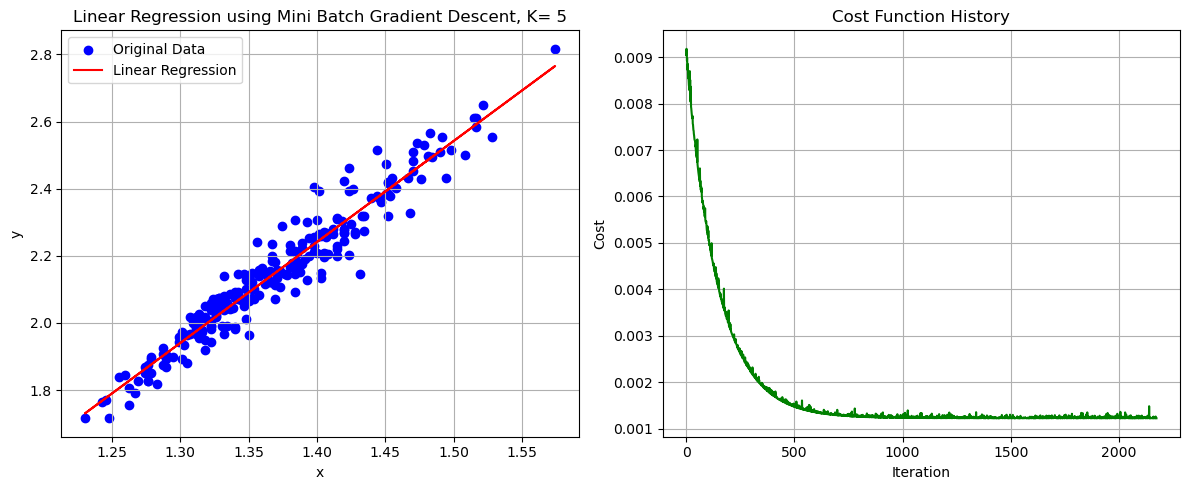

In [12]:
# 这一code block用来画出数据点和拟合直线
plot_data_and_line(x_values, y_values, theta_0_mini_batch, theta_1_mini_batch, cost_history_mini_batch,
                   'Linear Regression using Mini Batch Gradient Descent, K= ' + str(best_K))

## 3. 自适应梯度下降法 Adagrad（在学习率方面进行了改进）
$$ \begin{aligned}\theta^{(\mathbf{t+1})}{:}=\theta^{(\mathbf{t})}-\frac{a}{\sqrt{\sum_{i=0}^{t}(g^{(i)})^2}}g^{(t)}\end{aligned}$$
其中
$$ g^{(t)}=\frac{\partial J(\theta^{(t)})}{\partial\theta}$$

In [13]:
# 请注意这里的学习率，我将它设定的非常大，得益于adagrad的特性，我们可以使用更大的学习率
# 如果将学习率设定过小，会导致adagrad无法收敛，效果较差
# 所以，我们需要alpha也需要不断尝试与比较，来获取更好的效果
def adagrad_mini_batch_gradient_descent(x_values, y_values, batch_size=5, alpha=3, convergence_threshold=1e-8,
                                        max_iterations=10000):
    """
    Perform mini batch gradient descent with adaptive learning rate.
    
    :param x_values:  这是一个list，包含了所有的x值
    :param y_values:  这是一个list，包含了所有的y值
    :param batch_size:  这是一个int，表示batch的大小
    :param alpha:   这是一个float，表示学习率
    :param convergence_threshold:  这是一个float，表示收敛阈值
    :param max_iterations:  这是一个int，表示最大迭代次数
    :return:    这是一个tuple，包含了theta_0, theta_1, cost_history，分别表示最终的theta_0, theta_1和损失函数的变化
    """

    theta_0 = 0  # 初始化theta_0
    theta_1 = 0  # 初始化theta_1
    N = len(x_values)
    cost_history = []

    # 初始化sum_squared_gradients，这是用来计算学习率的
    sum_squared_gradients_0 = 0.0001  # 较小的值以避免被零除
    sum_squared_gradients_1 = 0.0001

    for _ in range(max_iterations):
        # 对数据进行随机打乱
        combined = list(zip(x_values, y_values))  # 将x_values和y_values打包成一个list
        random.shuffle(combined)  # 对打包后的list进行随机打乱
        x_values[:], y_values[:] = zip(*combined)  # 将打乱后的list解包赋值给x_values和y_values

        # Mini-batch updates
        # 这里的代码与batch gradient descent的代码类似，只是多了一个batch_size的参数
        for i in range(0, N, batch_size):
            x_batch = x_values[i:i + batch_size]
            y_batch = y_values[i:i + batch_size]
            sum_theta_0 = 0
            sum_theta_1 = 0
            for j in range(len(x_batch)):
                error = f_theta(x_batch[j], theta_0, theta_1) - y_batch[j]
                sum_theta_0 += error
                sum_theta_1 += error * x_batch[j]

            # 计算梯度
            # 计算公式为： theta_j = theta_j - alpha / (sum_squared_gradients_j ** 0.5) * 1/N * sum((f_theta(x_i) - y_i) * x_i)
            gradient_0 = (1 / batch_size) * sum_theta_0  # 计算theta_0的梯度
            gradient_1 = (1 / batch_size) * sum_theta_1  # 计算theta_1的梯度

            sum_squared_gradients_0 += gradient_0 ** 2  # 更新sum_squared_gradients_0
            sum_squared_gradients_1 += gradient_1 ** 2  # 更新sum_squared_gradients_1

            adaptive_alpha_0 = alpha / (sum_squared_gradients_0 ** 0.5)  # 计算theta_0的学习率
            adaptive_alpha_1 = alpha / (sum_squared_gradients_1 ** 0.5)  # 计算theta_1的学习率

            theta_0 -= adaptive_alpha_0 * gradient_0  # 更新theta_0
            theta_1 -= adaptive_alpha_1 * gradient_1  # 更新theta_1

        cost_history.append(compute_cost(x_values, y_values, theta_0, theta_1))

        if len(cost_history) > 1 and abs(cost_history[-1] - cost_history[-2]) < convergence_threshold:
            # 如果损失函数的变化小于收敛阈值，则停止迭代
            break

    return theta_0, theta_1, cost_history

In [14]:
# 这一code block用来调用上面的函数

# K值的选择需要我们不断尝试与比较，来获取更好的效果
possible_K_values = [3, 4, 5, 6, 7, 10]  # 可能得K值需要自己设定，对于不同的数据集，可能需要不同的K值
best_K = possible_K_values[0]
lowest_cost = float('inf')
theta_0_adaptive = 0
theta_1_adaptive = 0
cost_history_adaptive = []

for K in possible_K_values:  # 对于每一个K值
    theta_0_temp, theta_1_temp, cost_history_temp = adagrad_mini_batch_gradient_descent(x_values, y_values, K)
    if cost_history_temp[-1] < lowest_cost:
        lowest_cost = cost_history_temp[-1]
        best_K = K
        theta_0_adaptive = theta_0_temp
        theta_1_adaptive = theta_1_temp
        cost_history_adaptive = cost_history_temp

best_K, theta_0_adaptive, theta_1_adaptive, cost_history_adaptive[-1]

(4, -1.9766977855340355, 3.0124754891914933, 0.0012295624355104417)

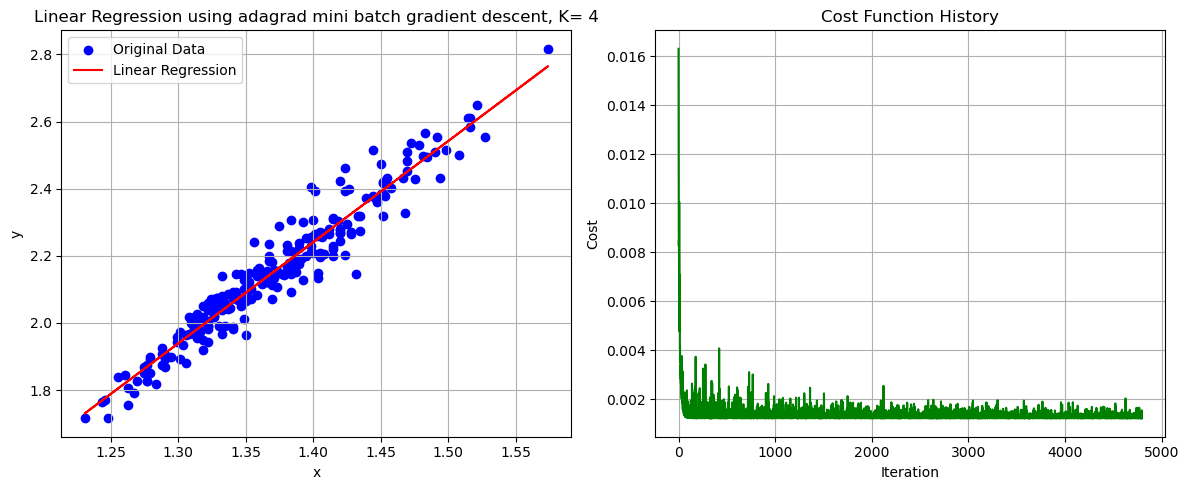

In [15]:
# 这一code block用来画出数据点和拟合直线
plot_data_and_line(x_values, y_values, theta_0_adaptive, theta_1_adaptive, cost_history_adaptive,
                   'Linear Regression using adagrad mini batch gradient descent, K= ' + str(best_K))

## 4. 多变量线性回归 Multivariate Linear Regression（在特征方面进行了改进，拓展到多个特征）
$$ f_\theta(x)=\theta_0+\theta_1x_1+\theta_2x_2+\cdots+\theta_nx_n$$
$$ J(\theta_0,\theta_1,...\theta_n)=\frac1{2N}\sum_{i=1}^N(f_\theta(x^{(i)})-y^{(i)})^2 $$

In [16]:
def multivariate_gradient_descent(X, y, batch_size=5, alpha=3, convergence_threshold=1e-8, max_iterations=10000):
    """
    Perform mini batch gradient descent with adaptive learning rate for multivariate linear regression.
    
    :param X:  这是一个矩阵，包含了所有的x值
    :param y:  这是一个list，包含了所有的y值
    :param batch_size:  这是一个int，表示batch的大小
    :param alpha:  这是一个float，表示学习率
    :param convergence_threshold:  这是一个float，表示收敛阈值
    :param max_iterations:  这是一个int，表示最大迭代次数
    :return:  这是一个tuple，包含了theta, cost_history，分别表示最终的theta和损失函数的变化，theta是一个list
    """
    m, n = X.shape  # m是样本数量，n是特征数量
    theta = np.zeros(n + 1)  # n+1 thetas 包含 theta_0
    X = np.hstack((np.ones((m, 1)), X))  # 在X前面加一列1，用来计算theta_0
    cost_history = []
    sum_squared_gradients = np.zeros(n + 1) + 0.0001  # 较小的值以避免被零除

    for _ in range(max_iterations):
        # 对数据进行随机打乱
        indices = np.arange(m)  # 生成一个0到m-1的list
        np.random.shuffle(indices)  # 对list进行随机打乱
        X = X[indices]  # 用打乱后的list对X进行重新排序
        y = y[indices]  # 用打乱后的list对y进行重新排序

        # Mini-batch updates
        for i in range(0, m, batch_size):  # i从0开始，每次增加batch_size
            X_batch = X[i:i + batch_size]  # 从i开始，取batch_size个元素
            y_batch = y[i:i + batch_size]  # 从i开始，取batch_size个元素

            # 梯度计算公式为： theta_j = theta_j - alpha / (sum_squared_gradients_j ** 0.5) * 1/N * sum((f_theta(x_i) - y_i) * x_i) 
            gradient = (1 / batch_size) * X_batch.T.dot(X_batch.dot(theta) - y_batch)  # 计算梯度
            sum_squared_gradients += gradient ** 2  # 更新sum_squared_gradients
            adaptive_alpha = alpha / np.sqrt(sum_squared_gradients)  # 计算学习率
            theta -= adaptive_alpha * gradient  # 更新theta

        cost = (1 / (2 * m)) * np.sum((X.dot(theta) - y) ** 2)  # 计算损失函数的值
        cost_history.append(cost)

        if len(cost_history) > 1 and abs(cost_history[-1] - cost_history[-2]) < convergence_threshold:
            # 如果损失函数的变化小于收敛阈值，则停止迭代
            break

    return theta, cost_history

In [17]:
# 这一code block用来调用上面的函数
# 请注意，这里的数据集是多变量线性回归的数据集
X_matrix = data[['x']].values
y_vector = data['y'].values
# best_K 已经在上面的代码中被赋值
theta_multivariate, cost_history_multivariate = multivariate_gradient_descent(X_matrix, y_vector, best_K)

theta_multivariate, cost_history_multivariate[-1]

(array([-1.97841918,  3.0175544 ]), 0.001241377841692704)

## 5. L1正则化 L1 Regularization（在正则化方面进行了改进）

[线性回归——lasso回归和岭回归（ridge regression） - wuliytTaotao - 博客园 (cnblogs.com)](https://www.cnblogs.com/wuliytTaotao/p/10837533.html)

In [18]:
def lasso_gradient_descent(X, y, batch_size=5, lambda_=0.1, alpha=3, convergence_threshold=1e-8, max_iterations=10000):
    """Perform mini batch gradient descent with adaptive learning rate and L1 regularization for multivariate linear regression."""
    m, n = X.shape  # m是样本数量，n是特征数量
    theta = np.zeros(n + 1)  # n+1 thetas 包含 theta_0
    X = np.hstack((np.ones((m, 1)), X))  # 在X前面加一列1，用来计算theta_0
    cost_history = []
    sum_squared_gradients = np.zeros(n + 1) + 0.0001  # 较小的值以避免被零除

    for _ in range(max_iterations):
        # 对数据进行随机打乱
        indices = np.arange(m)  # 生成一个0到m-1的list
        np.random.shuffle(indices)  # 对list进行随机打乱
        X = X[indices]  # 用打乱后的list对X进行重新排序
        y = y[indices]  # 用打乱后的list对y进行重新排序

        # Mini-batch updates
        for i in range(0, m, batch_size):  # i从0开始，每次增加batch_size
            X_batch = X[i:i + batch_size]  # 从i开始，取batch_size个元素
            y_batch = y[i:i + batch_size]  # 从i开始，取batch_size个元素

            # Compute gradient (including L1 penalty for j > 0)
            gradient = (1 / batch_size) * X_batch.T.dot(X_batch.dot(theta) - y_batch)  # 计算梯度
            gradient[1:] += lambda_ * np.sign(theta[1:])  # 对除theta_0外的所有theta添加L1正则化

            sum_squared_gradients += gradient ** 2  # 更新sum_squared_gradients
            adaptive_alpha = alpha / np.sqrt(sum_squared_gradients)  # 计算学习率
            theta -= adaptive_alpha * gradient  # 更新theta

        # Compute cost (including L1 penalty for j > 0)
        cost = (1 / (2 * m)) * np.sum((X.dot(theta) - y) ** 2) + lambda_ * np.sum(np.abs(theta[1:]))
        cost_history.append(cost)

        if len(cost_history) > 1 and abs(cost_history[-1] - cost_history[-2]) < convergence_threshold:
            # 如果损失函数的变化小于收敛阈值，则停止迭代
            break

    return theta, cost_history

如何选择lambda？

In [19]:
def determine_best_lambda(X, y, lambdas, num_folds=5, **kwargs):
    """Determine the best lambda using K-fold cross validation."""
    from sklearn.model_selection import KFold  # 此处使用sklearn中的KFold函数，用来进行交叉验证，与线性回归无关
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # 生成交叉验证的数据,42是随机种子
    average_errors = []  # 用来保存每一个lambda的平均误差

    for lambda_ in lambdas:  # 对于每一个lambda
        fold_errors = []  # 用来保存每一折的误差

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]  # 生成训练集和验证集
            y_train, y_val = y[train_index], y[val_index]  # 生成训练集和验证集

            theta, _ = lasso_gradient_descent(X_train, y_train, lambda_=lambda_, **kwargs)  # 训练模型

            # Compute validation error
            y_pred = np.hstack((np.ones((X_val.shape[0], 1)), X_val)).dot(theta)  # 计算预测值
            error = (1 / (2 * X_val.shape[0])) * np.sum((y_pred - y_val) ** 2)  # 计算误差
            fold_errors.append(error)

        average_errors.append(np.mean(fold_errors))

    best_lambda = lambdas[np.argmin(average_errors)]  # 选择平均误差最小的lambda
    return best_lambda, average_errors

In [20]:
# Lambda values to test
lambdas = [0, 0.001, 0.01, 0.1, 1, 10]

best_lambda, average_errors = determine_best_lambda(X_matrix, y_vector, lambdas)
best_lambda, average_errors

(0,
 [0.0012479561196822458,
  0.0013787014796921503,
  0.014505090866243495,
  0.019862491343947526,
  0.01962403184726454,
  0.01954528009945101])

In [21]:
# Apply the multivariate gradient descent (using the single feature we have for this dataset)
X_matrix = data[['x']].values
y_vector = data['y'].values
theta_lasso, cost_history_lasso = lasso_gradient_descent(X_matrix, y_vector, best_K, best_lambda)

theta_lasso, cost_history_lasso[-1]

(array([-1.97780582,  3.01758047]), 0.001244750857224212)

分界线——终止
算法设计部分，为完整的思维过程，含相关函数的使用范例，非必要请勿修改